# Variational AutoEncoder and Beyond





Unsupervised learning and generative models are key building blocks of machine learning systems. This tutorial covers a specific class of unsupervised models called autoencoders. Autoencoders have been a popular model of choice for learning representations of data as well as modeling the data distribution.

We implement and train three variants:
* the original vanilla autoencoder,
* variational autoencoder, and
* as homework the recently introduced regularized autoencoders.

Along with training these, we examine and investigate their generative modeling capabilities.

## Organization

We start by loading all libraries and inspecting the data.

In the first part of the tutorial we will train an AutoEncoder. This will serve as a foundation for implementing and understanding Variational AutoEncoders. The homework will be to implement Regularized AutoEncoder, a recent model that generates good samples but foregoes the need to use variational inference.


# Task 1: Install haiku and load data

This code is all written for you. You only need to run it and inspect the returned data.

In [1]:
#@title RUN this cell to install and import required libraries
!pip install -q dm-haiku

from typing import Any, Generator, Mapping, Tuple, NamedTuple, Sequence

from collections import defaultdict, namedtuple
from absl import app
from absl import flags
from absl import logging
import haiku as hk
import jax
from jax.experimental import optix
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.image
import tensorflow_datasets as tfds

import scipy.stats

import functools

%matplotlib inline


     |████████████████████████████████| 235kB 2.9MB/s 


In [2]:
#@title Python Type Declarations
OptState = Any
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)

CLASS_LABELS = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
    'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
    # 'zero', 'one', 'two', 'three', 'four', 'five', 'six',
    # 'seven', 'eight', 'nine'
]


In [3]:
#@title Utility Functions for Data

def gallery(
    images, labels: Sequence[int] = None,
    max_images: int = 10, max_fig_size=(30, 30)):
  
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, max_images)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=max_fig_size,
                          subplot_kw={'xticks': [], 'yticks': []})
  if num_frames == 1:
    axes = [axes]

  # All outputs in the notebook are supposed to be between 0 and 1
  images = np.clip(images, 0.0, 1.0)
  
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    if labels is not None:
      axes[i].set_title(CLASS_LABELS[labels[i]], fontsize=28)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()

def load_dataset(split: str, batch_size: int) -> Generator[Batch, None, None]:
  ds = tfds.load("fashion_mnist", split=split, shuffle_files=True)
  def normalize(inp):
    inp['image'] = tensorflow.image.convert_image_dtype(
        inp['image'], tensorflow.float32)
    return inp
  ds = ds.map(normalize)
  ds = ds.repeat(2)  # To shuffle across epoch boundary.
  SHUFFLE_LENGTH = 50
  ds = ds.shuffle(buffer_size=SHUFFLE_LENGTH * batch_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=5)
  ds = ds.repeat()
  return tfds.as_numpy(ds)

We will be using the Fashion MNIST dataset; let's download it and inspect it.

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteNSC1L9/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteNSC1L9/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


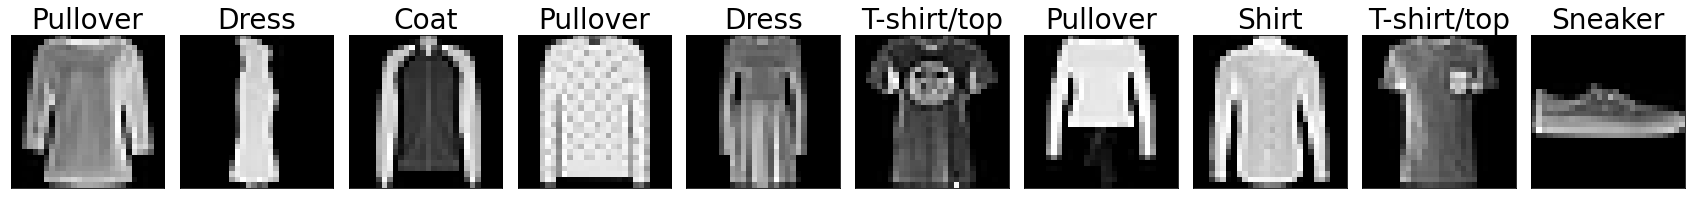

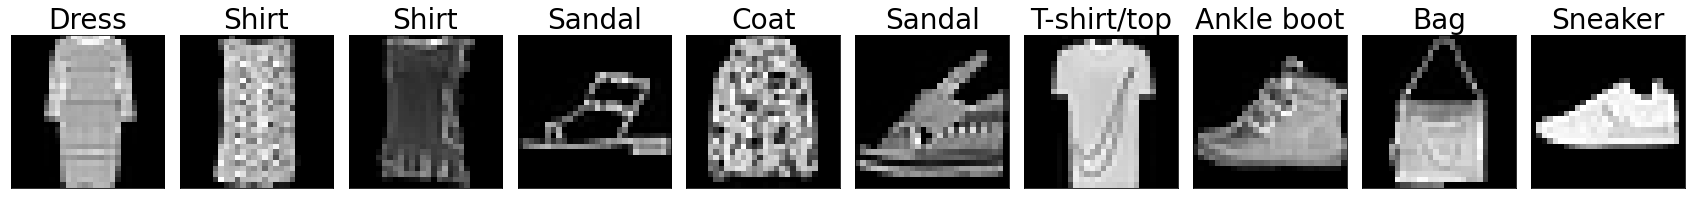

In [4]:
#@title Load and visualize the dataset we will be working with

train = load_dataset("train", batch_size=128);
batch = next(train)
for i in range(0, 20, 10):
  gallery(batch['image'][i:i+10], batch['label'][i:i+10])


Let's get to know our data a bit more. Find out the following information (search it up or inspect data):

* the classes,
* shape of data,
* representation of each pixel.

Do note that we applied some processing on the data!

In [5]:
# Feel free to play with data here.


In [6]:
#@title Run checks
assert batch['image'].shape == (128, 28, 28, 1)
print("Congratulations! You have completed Task 1.")

Congratulations! You have completed Task 1.


# Task 2: Implement and train an AutoEncoder (AE)

<center>
<img src="https://www.dropbox.com/s/zmvci77ih2u350k/ae.png?dl=1">
</center>

AutoEncoders map (*encode*) their input into a new representation, then map (*decode*) that new representation back into the input space, with the goal of reconstructing the input.

If the input is denoted by $x$, the encoder $E$ and the decoder $D$, the reconstruction is $\hat{x} = D(E(x))$. In order to encourage reconstruction, we will minimize the mean squared error

<font size=4>
$$ \mathcal{L}(x, \hat{x}) = \big|\big|x - D \big(E(x)\big)\big|\big|^2.$$
</font>

<br />

The space of representations is often called the latent space. We are interested in AEs as this latent space can potentially be a smaller dimensional and better representation of our data. We may also generate new data examples with an autoencoder, but let's return to this later.



We will first implement the autoencoder model, then the training mechanism. Much of the code is given, however you need to fill in some of its key components.



### Modeling

For an encoder with a single linear hidden layer with ReLU before mapping to the latent, ie $\mathrm{Encoder}(x) = z$ where:

$$
h_0 := \mathrm{ReLU}(W_0 x + b_0)  \\
z := W_1 h_0 + b_1  \\
$$

We will use two such hidden linear layers for more capacity.


In [8]:
#@title Encoder
class Encoder(hk.Module):
  """Encoder with linear layers and ReLU."""

  def __init__(
      self,
      hidden_sizes: Sequence[int] = (512, 512),
      latent_size: int = 10
    ):
    super().__init__()
    self._hidden_sizes = hidden_sizes
    self._latent_size = latent_size

  def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    x = hk.Flatten()(x) # (batch_size, w, d) -> (batch_size, w*d)
    # ADD CODE BELOW to calculate the returned z latent. --------
    for hs in self._hidden_sizes:
      x = hk.Linear(hs)(x)
      x = jax.nn.relu(x)
    z = hk.Linear(self._latent_size)(x)

    # Your code ABOVE. ------------------------------------------
    return z


In [9]:
#@title Run checks on Encoder implementation
# Requires a bit of boilerplate.
rng_seq = hk.PRNGSequence(42)
model = hk.transform(lambda x: Encoder(latent_size=2)(x), apply_rng=False)  
params = model.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
assert model.apply(params, jnp.zeros(shape=(128, 28, 28, 1))).shape == (128, 2)
print("Congratulations! Encoder implementation looks good.")

Congratulations! Encoder implementation looks good.


Our decoder is similar. For a decoder that's a sequence of two linear maps with a ReLU we have $\mathrm{Decoder}(z) = \hat{x}$ where:

$$
h_0' := \mathrm{ReLU}(W_0' z + b_0')  \\
\hat{x} := W_1' h_0' + b_1'  \\
$$

We will use two hidden linear layers for more capacity.


In [10]:
#@title Decoder

class Decoder(hk.Module):
  """Decoder model."""

  def __init__(
      self,
      hidden_sizes: Sequence[int] = (512, 512),
      output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
  ):
    super().__init__()
    self._hidden_sizes = hidden_sizes
    self._output_shape = output_shape

  def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
    flat_data_dimension = jnp.prod(self._output_shape)
    h = z
    # ADD CODE BELOW to map back to the data space. --------
    # Note, the final reshape is done for you below, you need to calculate
    # `flat_x_reconstructed` which is a batch of flat_data_dimension-long
    # vectors.
    for hs in self._hidden_sizes:
      h = hk.Linear(hs)(h)
      h = jax.nn.relu(h)
    flat_x_reconstructed = hk.Linear(flat_data_dimension)(h)

    # Your code ABOVE. ------------------------------------------

    x_reconstructed = jnp.reshape(
        flat_x_reconstructed, (-1, *self._output_shape))

    return x_reconstructed



In [11]:
#@title Run checks on Decoder implementation
# (requires a bit of boilerplate)
rng_seq = hk.PRNGSequence(42)
model = hk.transform(lambda x: Decoder(hidden_sizes=(512, 256), output_shape=(14,14))(x), apply_rng=False)  
params = model.init(next(rng_seq), jnp.zeros((1, 2)))
assert model.apply(params, jnp.zeros(shape=(128, 2))).shape == (128, 14, 14)
print("Congratulations! Decoder implementation looks good.")

Congratulations! Decoder implementation looks good.


Finally we combine the encoder and decoder into an AutoEncoder!

In [12]:
#@title AutoEncoder

class AutoEncoder(hk.Module):
  """Main AE model class, uses Encoder & Decoder under the hood."""

  def __init__(
      self,
      hidden_sizes: Sequence[int] = (512, 512),
      latent_size: int = 10,
      output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
  ):
    super().__init__()
    self._hidden_sizes = hidden_sizes
    self._latent_size = latent_size
    self._output_shape = output_shape
    self._encoder = Encoder(self._hidden_sizes, self._latent_size)
    self._decoder = Decoder(self._hidden_sizes, self._output_shape)

  def reconstruct(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    z = self._encoder(x)
    x_rec = self._decoder(z)
    return x_rec, z

  def sample(self, z: jnp.ndarray) -> Tuple[jnp.ndarray]:
    return self._decoder(z)
    

### Training

To complete the training script we need code for:

1. the loss function,
2. constructing a model and updating its parameters based on data,
3. fetching the data and making the parameter updates.

How would you
* qualitatively evaluate these reconstructions?
* quantitatively evaluate your model?



In [13]:
def mse_loss(model_outputs: jnp.ndarray, true_images) -> jnp.ndarray:
  """Mean Squared Error loss function."""
  # ADD CODE BELOW to calculate the MSE between the true data and --------
  # the reconstruction.

  mse = jnp.mean(jnp.power(model_outputs - true_images, 2.0))

  # Your code ABOVE. ------------------------------------------
  return mse


We create a model and an optimizer, then an update function that works with these. While the code is already written for you, do check it out.

In [14]:
AE_LATENT_SIZE = 2  # This is so we can visualize it easily.
ae_model = hk.transform(
    lambda x: AutoEncoder(latent_size=AE_LATENT_SIZE).reconstruct(x), apply_rng=True)  
ae_optimizer = optix.adam(0.0001)


@jax.jit
def mse_of_reconstruction(
    params: hk.Params, rng_key: PRNGKey, data_batch) -> jnp.ndarray:
  outputs, _ = ae_model.apply(params, rng_key, data_batch["image"])
  return mse_loss(outputs, data_batch['image'])


@jax.jit
def update(
    params: hk.Params, rng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
  """Single update step."""
  grads = jax.grad(mse_of_reconstruction)(params, rng_key, batch)
  loss = mse_of_reconstruction(params, rng_key, batch)
  updates, new_opt_state = ae_optimizer.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, new_opt_state, loss


Finally we hook everything up. During the course of training we will show reconstructions on the validation data set.

STEP: 0; Validation loss: 0.18510499596595764


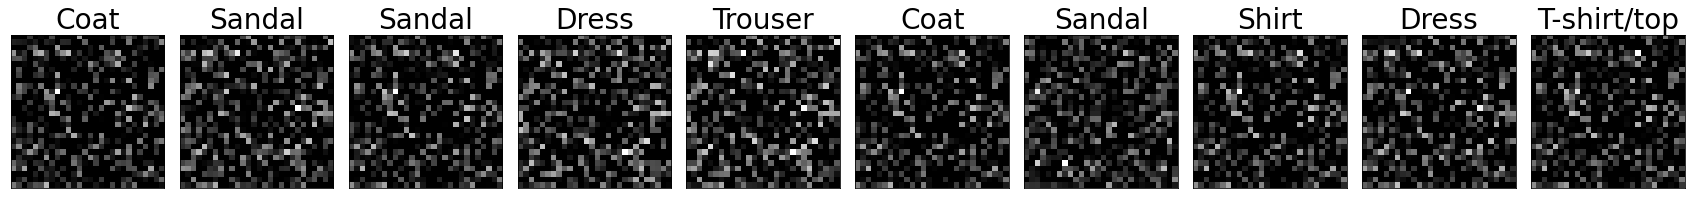

STEP: 100; Validation loss: 0.04932038486003876


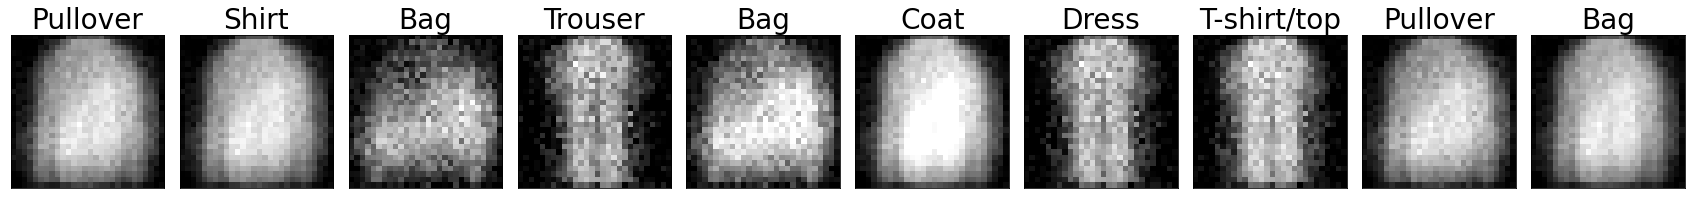

STEP: 200; Validation loss: 0.03745121881365776


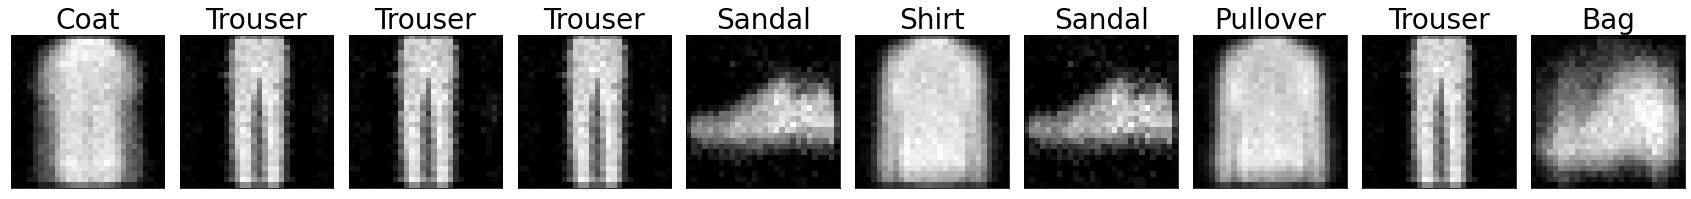

STEP: 300; Validation loss: 0.03678327426314354


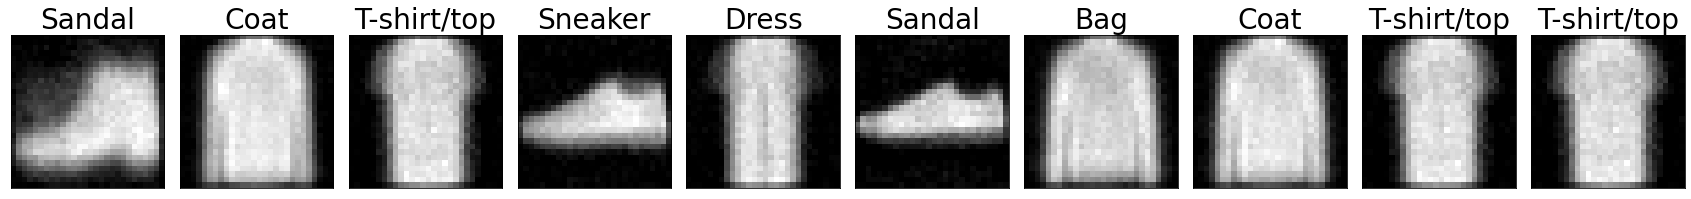

STEP: 400; Validation loss: 0.03728023171424866


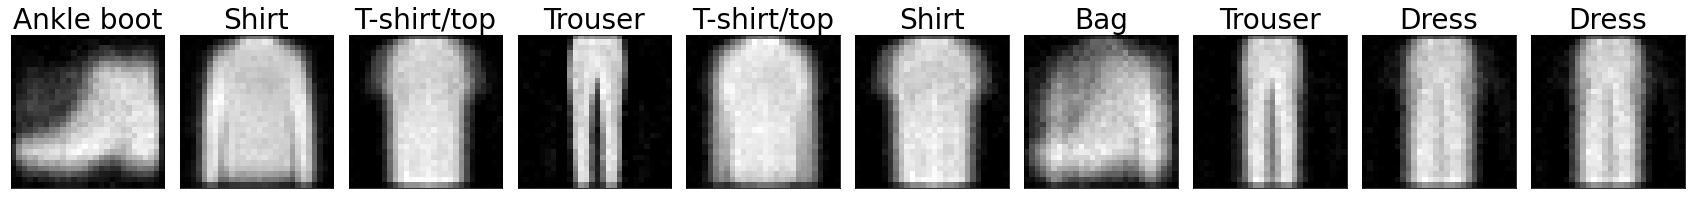

STEP: 500; Validation loss: 0.03849028795957565


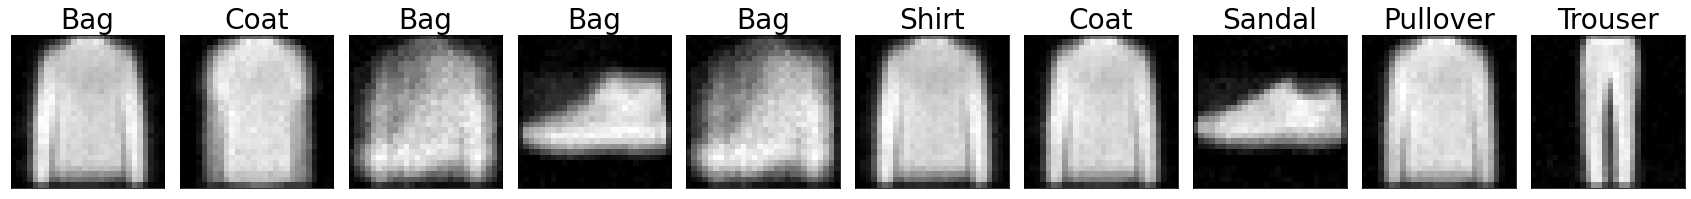

STEP: 600; Validation loss: 0.03289249911904335


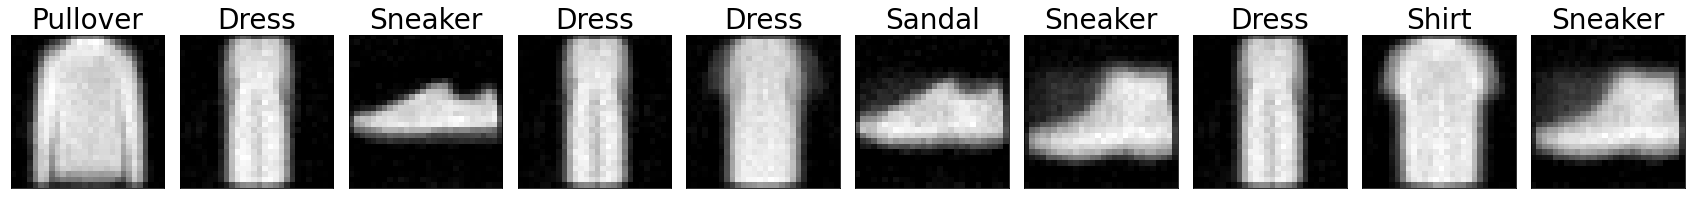

STEP: 700; Validation loss: 0.035472456365823746


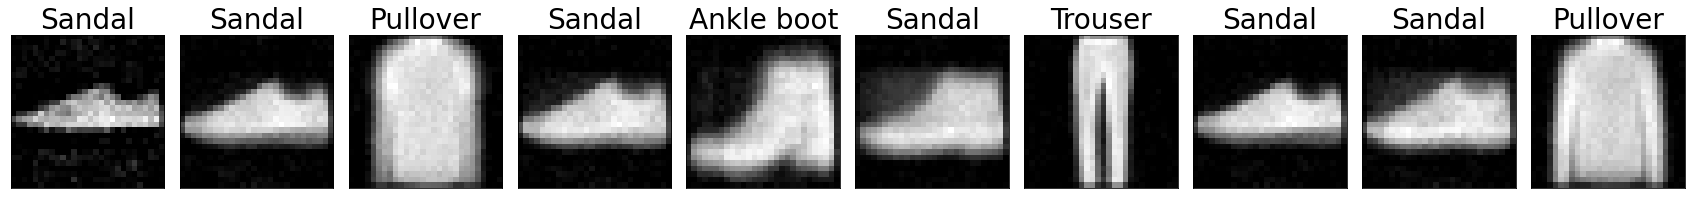

STEP: 800; Validation loss: 0.031241262331604958


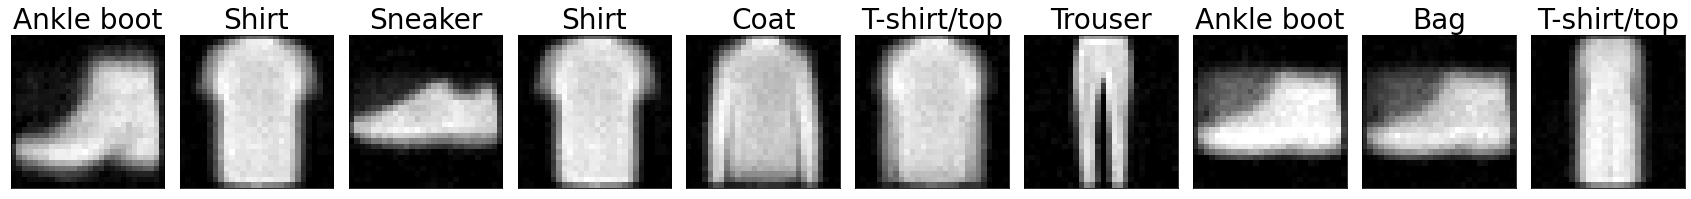

STEP: 900; Validation loss: 0.03362978622317314


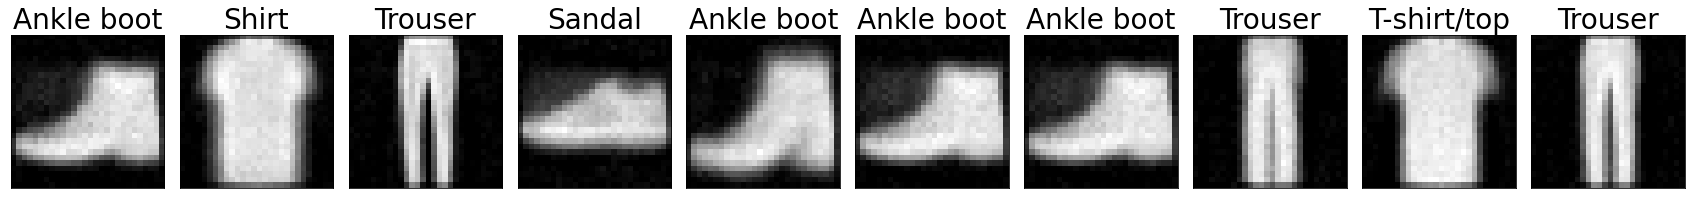

In [15]:
RANDOM_SEED = 13
rng_seq = hk.PRNGSequence(RANDOM_SEED)
ae_params = ae_model.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = ae_optimizer.init(ae_params)

train_ds = load_dataset(tfds.Split.TRAIN, 128)
valid_ds = load_dataset(tfds.Split.TEST, 128)
# IMPORTANT! Normally you would use a different validation and test set.

training_stats = defaultdict(list)
for step in range(1000):
  ae_params, opt_state, loss = update(ae_params, next(rng_seq), opt_state, next(train_ds))
  
  if step % 100 == 0:
    valid_batch = next(valid_ds)
    rng_key = next(rng_seq)
    val_loss = mse_of_reconstruction(ae_params, rng_key, valid_batch)
    print(f"STEP: {step}; Validation loss: {val_loss}")
    
    training_stats['val_loss'].append(val_loss)
    training_stats['train_loss'].append(loss)
    training_stats['step'].append(step)

    valid_rec, _ = ae_model.apply(ae_params, rng_key, valid_batch["image"])
    gallery(valid_rec, valid_batch['label'])

We show originals and reconstructions on the training and validation sets. Doing this on the training set is already done for you, you need to do it for the validation set.

Training set original then reconstruction under it:


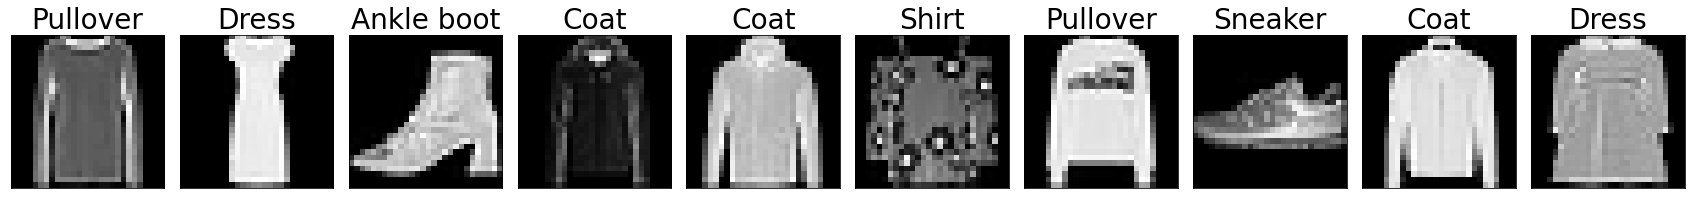

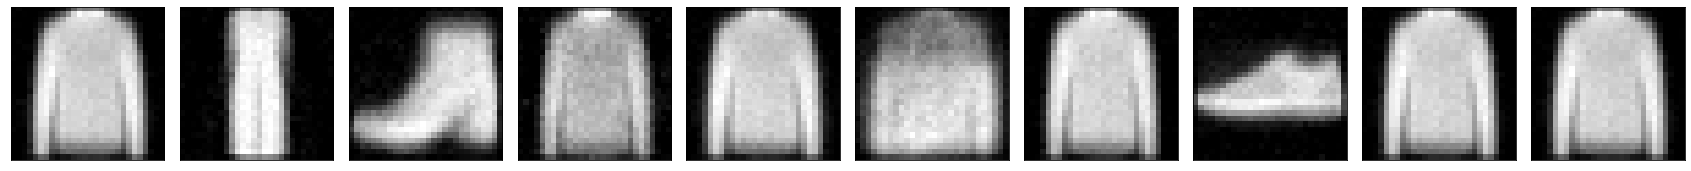

Validation set original then reconstruction under it:


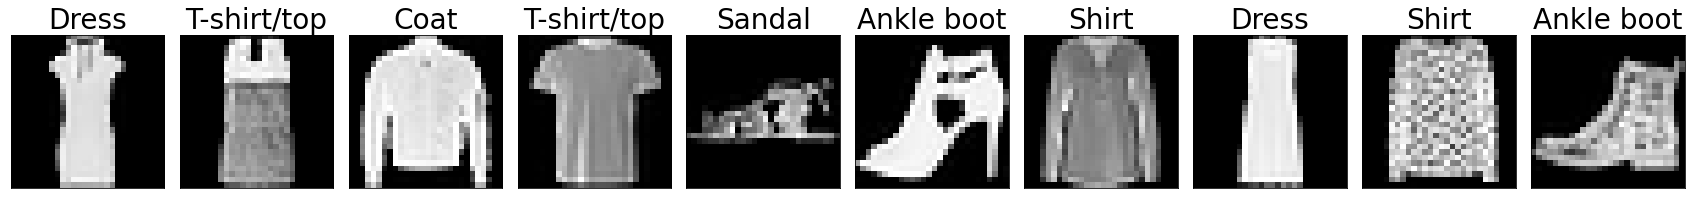

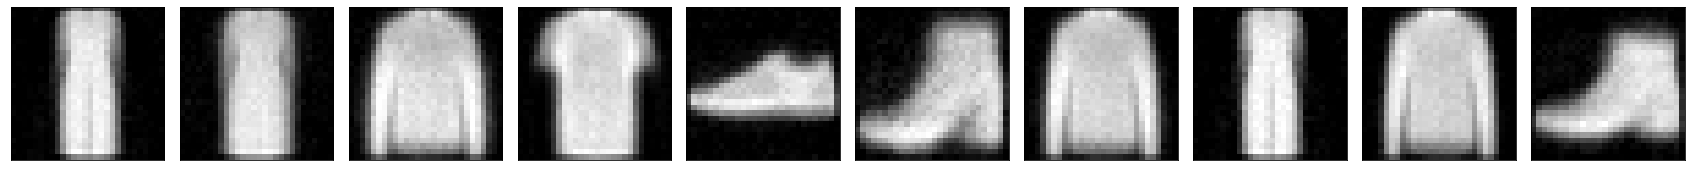

In [16]:
train_batch = next(train_ds)
valid_batch = next(valid_ds)

print("Training set original then reconstruction under it:")
train_rec, _ = ae_model.apply(ae_params, rng_key, train_batch["image"])
gallery(train_batch['image'], train_batch['label'])
gallery(train_rec)

print("Validation set original then reconstruction under it:")
# ADD CODE BELOW to get the sample(s). --------
valid_rec, _ = ae_model.apply(ae_params, rng_key, valid_batch["image"])
gallery(valid_batch['image'], valid_batch['label'])
gallery(valid_rec)

# Your code ABOVE. ------------------------------------------


Let's check the training and validation losses. Run the checks in the cell after to verify that it is roughly on the right scale.

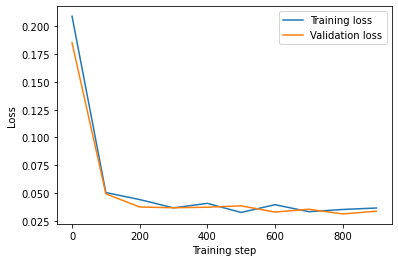

In [17]:
plt.plot(training_stats['step'], training_stats['train_loss'], label="Training loss")
plt.plot(training_stats['step'], training_stats['val_loss'], label="Validation loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.legend()

In [18]:
# Run checks
assert min(training_stats['train_loss']) < 0.050
print("Congratulations! Your trained your AutoEncoder.")

Congratulations! Your trained your AutoEncoder.


**Questions:**

* What can you say given the training and validation losses you see? 
* Do you think overall this works well?
* Do you see some systematic problems?
* Why do you think bags are poorly reconstructed?

Finally, hypothetically speaking, what mechanism would you us to create new images? Give this a little thought before continuing, we'll circle back to it!


# Task 3: Playing with the latent space of our AE




### Visualization of the latent space

We trained an autoencoder with a 2D latent space, making it easy to visualize what latents --what representations-- data gets mapped to.

We will plot $\mathrm{E}(x)$ for 10 batches of validation data, colouring them by their class.

Before looking at the visualization, let's think about what you may expect it to look like. Here are some questions, but feel free to think up more:
* Do you expect data from the same classes to be close to each other or not?
* Can you think of some choices in our model and/or training that has an effect on the latent space?
* What parts of the latent space will be covered? Will there be "holes" in the latent space?

You could even make a quick sketch in paper of what you may expect to see.

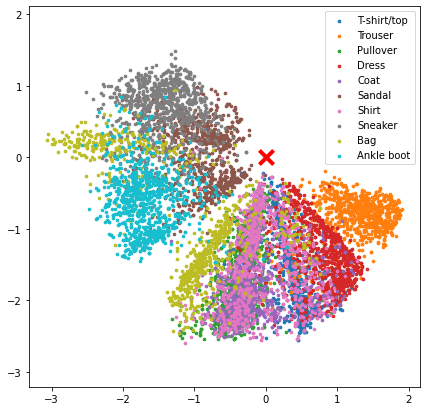

In [19]:
h, y = [], []
for _ in range(75):
  valid_batch = next(valid_ds)
  h.append(ae_model.apply(ae_params, next(rng_seq), valid_batch["image"])[1])
  y.append(valid_batch['label'])
h = np.concatenate(h, axis=0)
y = np.concatenate(y, axis=0)
plt.figure(figsize=(7,7))
# plt.grid()
for yy in range(10):
  plt.scatter(h[y==yy][:, 0], h[y==yy][:, 1], label=CLASS_LABELS[yy], s=7)

plt.scatter([0],[0], marker="x", s=200, color="red", linewidth=4)
plt.axis('equal')
plt.legend()


Is this similar to your expectations? Do note that this was just a single run with a single initialization -- does rerunning with a *different random seed* change the image considerably?

If you haven't thought about how you would generate a new image yet, this is the time since we will be giving it away in the next section!


### Generating new data

In order to generate some new data, we will simply decode (with $D$) a point in the latent space. The code for setting this up is provided below, you'll have to use it to create the new image.

Before running the code try to think about what will happen if you decode from the (0, 0) (red mark in the previous plot)?

In [20]:
# How this works with jax and haiku:
# 
# Recall, our autoencoder had a reconstruct and a sample function. Both of
# these function shared the same decoder. We already trained the decoder --
# as part of the model. The trained parameters are in `ae_params`.
#
# We create a new ae_sampler model and simply inject these sampling params
# from `ae_params` into the model.
ae_sampler = hk.transform(
    lambda x: AutoEncoder(latent_size=AE_LATENT_SIZE).sample(x), apply_rng=True)  

params_for_sampling = ae_sampler.init(
    next(rng_seq), jnp.zeros((1, AE_LATENT_SIZE)))

# Use the trained parameters from the autoencoder for sampling.
ae_params  # has keys like ... 'auto_encoder/~/decoder/linear', 'auto_encoder/~/decoder/linear_1', 'auto_encoder/~/encoder/linear', 'auto_encoder/~/encoder/linear_1'
params_for_sampling  # has keys 'auto_encoder/~/decoder/linear', 'auto_encoder/~/decoder/linear_1'

trained_params_for_sampling = {}
for key in params_for_sampling:
  trained_params_for_sampling[key] = ae_params[key]


**Exercise.** Decode some points in the latent space and visualize them.  Start with the point (0, 0).

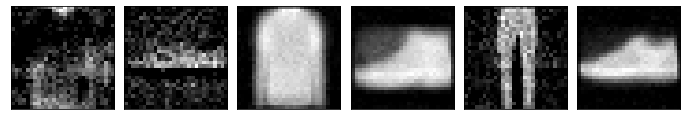

In [21]:
# ADD CODE BELOW to get the sample(s). --------
# You can use ae_sample as ae_sampler.apply(params, next(rng_seq), z)
z = jnp.array([
    [0, 0],
    [0, 1],
    [0, -1],
    [-1, 0],
    [1, 0],
    [-1.5, 0.5],
])
sample = ae_sampler.apply(trained_params_for_sampling, next(rng_seq), z)


# Your code ABOVE. ------------------------------------------

gallery(sample, max_fig_size=(min(2*sample.shape[0], 20), 2))




What did you observe when sampling across the latent space? Did the example decoded from the (0, 0) point match your expectation?


**Question:** what could you do to automate the process of picking latents that will decode into nice images?

# Task 4: Implement and train a Variational AutoEncoder


Variational AutoEncoders (VAEs) also have an encoder, a decoder and try to reproduce data. However VAEs aim to learn the distribution of data and not simply reconstruct individual images.

Here both the encoder and the decoder can be stochastic and we get to think about distributions in the latent and data spaces. This story gets a bit more complex than that of a vanilla AutoEncoder, so let us start by introducing the characters:

* $P^*$ is the true data distribution. We have some samples from this.
* $p(z)$ is a *prior* distribution over the latent space.
* $E(x)$ the encoder retains its role, except now it outputs distributions over the latent space $Z$, not just elements of it. The produced distribution is denoted $q_\phi(z|x)$ and is the (approximate) *posterior* distribution.
* $D(z)$ the decoder may be stochastic again, modeling the likelihood distribution $p_\theta(x|z)$.

Now we go over the reconstruction and sampling process and finally motivate the loss used in VAEs.

### Reconstruction
The process for reconstruction is still simple:

1. Take $x_0 \sim P^*$.
2. Encode it $E_\phi(x_0)$, yielding $q_\phi(z|x_0)$.
3. Sample a latent $z_0 \sim q_\phi(z|x_0)$.
4. Decode the latent $p_\theta(x|z_0) = D_\theta(z_0)$.
5. Sample a reconstruction: $x_0 \sim p_\theta(x|z_0)$.

The prior has not showed up here, it plays a role in sampling.

<center><img src="https://drive.google.com/uc?export=view&id=1auGKK_J6nbQi1nw4fSNcJ2wqjVLzAJk5" width="450" alt="Illustration of VAE reconstruction and sampling" /></center>

### Sampling
The sampling process is still simple and reminiscent of our data generation in the AutoEncoder:

1. Sample a latent $z_0 \sim p(z)$ from the prior.
2. Decode the latent $p_\theta(x|z_0) = D_\theta(z_0)$.
3. Sample a reconstruction: $x_0 \sim p_\theta(x|z_0)$.

In practice we usually use simple, parametrizable distributions in the encoder and decoder. More specifically..

**Encoder**
Each latent dimension is a (univariate) gaussian, parametrized by the mean and standard deviation. Note, this is the same as a multivariate guassian over the latent space with a diagional covariance matrix.

**Decoder**
We will quantize the pixels to 0 and 1, which allows us to use a Bernoulli distribution per pixel to model it. Though for visualizations we will continue to use grayscale values.



## Modeling

Let's implement our model!

Our Encoder uses a two hidden layer before mapping into latent space. It now outputs a guassian distribution; we can achieve this by outputting (and later learning) the mean and the variance for the gaussian.

Mathematically speaking (with one hidden layer), for input $x$:

$$
h_0 := \mathrm{ReLU}(W_0 x + b_0)  \\
\mu := W_1 h_0 + b_1  \\
\log \sigma := W_2 h_0 + b_2  \\
$$

where $\mu, \log \sigma$ are vectors of length `latent_size`. Then

$$q_\phi(z|x) = \mathcal{N}(\mu, \mathrm{diag}( \sigma^2) ).$$

**Question:** why do we do $\log \sigma := W_2 h_0 + b_2$ instead of simply $\sigma := W_2 h_0 + b_2$? Can you think of other alternatives?



In [ ]:
class VAEEncoder(hk.Module):
  """VAE Encoder model."""

  def __init__(
      self,
      hidden_sizes: Sequence[int] = (512, 512),
      latent_size: int = 10):
    super().__init__()
    self._hidden_sizes = hidden_sizes
    self._latent_size = latent_size

  def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    h = hk.Flatten()(x)
    for hs in self._hidden_sizes:
      h = hk.Linear(hs)(h)
      h = jax.nn.relu(h)

    # ADD CODE BELOW to find mean (\mu) and standard deviation (\sigma). ------
    # They should be of size self._latent_size.
    mean = hk.Linear(self._latent_size)(h)
    log_stddev = hk.Linear(self._latent_size)(h)
    stddev = jnp.exp(log_stddev)   # Could also use softplus: log(1+e^x).
    # Your code ABOVE. --------------------------------------------------------

    return mean, stddev


We will reuse the Decoder from the autoencoder, though we will need to tweak its output so it can be used as a parameter for the Bernoulli distribution. We will pass the output through a sigmoid to smoothly bring it into a the [0,1] range.

In the cell below there are two sections to fill:
1. Combining the encode and decode functions into a "reconstruction" function.
2. Completing the code for sampling from $\mathcal{N}(\mu, \sigma^2)$,


In [ ]:
RecOutput = namedtuple(
    'RecOutput',
    ['mean_image', 'sampled_image', 'logits', 'z', 'mean', 'stddev']
)


class VariationalAutoEncoder(hk.Module):
  """Main VAE model class, uses Encoder & Decoder under the hood."""

  def __init__(
      self,
      hidden_sizes: Sequence[int] = (512, 512),
      latent_size: int = 10,
      output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
  ):
    super().__init__()
    self._hidden_sizes = hidden_sizes
    self._latent_size = latent_size
    self._output_shape = output_shape
    self._encoder = VAEEncoder(self._hidden_sizes, self._latent_size)
    self._decoder = Decoder(self._hidden_sizes, self._output_shape)

  def reconstruct(self, x):
    # ADD CODE BELOW combining self.encode() and self.decode() ------
    z, (mean, stddev) = self.encode(x)
    logits, mean_image, sampled_image = self.decode(z)
    # Your code ABOVE. ------------------------------------------
    return RecOutput(mean_image, sampled_image, logits, z, mean, stddev)

  def encode(self, x):
    """Return a single sample from q_\phi(z|x). Also return mean and stddev."""
    mean, stddev = self._encoder(x)
    # We sample from N(0, 1), and scale and shift the distribution to make
    # it distributed according to N(mean, stddev^2).
    normal_sample = jax.random.normal(hk.next_rng_key(), mean.shape)

    # ADD CODE BELOW to scale and shift the sample into the required `z` ------
    # You can use the fact that for X ~ N(mu, sigma^2), real constants a, c:
    # cX ~ N(c * mu, c^2 * sigma^2)
    # a + X ~ N(a + mu, sigma^2)
    # 
    # Work out how to turn a sample from N(0, 1) into one from
    # N(mean, stddev^2).
    z = mean + stddev * normal_sample
    # Your code ABOVE. ------------------------------------------
    return z, (mean, stddev)

  def decode(self, z):
    """Decode z into the bernoulli params and a sample from them."""
    logits = self._decoder(z)
    mean_image = jax.nn.sigmoid(logits)
    sampled_image = jax.random.bernoulli(hk.next_rng_key(), mean_image)
    return logits, mean_image, sampled_image

  def sample(self): 
    """Sample from the prior (see Sampling section at the beginning 
    of this section)."""
    z = jax.random.normal(hk.next_rng_key(), (1, self._latent_size))  
    logits, mean_image, sampled_image = self.decode(z)
    return mean_image, sampled_image, z


In [ ]:
rng_seq = hk.PRNGSequence(42)
test_model = hk.transform(
    lambda x: VariationalAutoEncoder(output_shape=(7,7)).reconstruct(x),
    apply_rng=True)
test_params = test_model.init(next(rng_seq), jnp.zeros((1, 3)))
assert test_model.apply(
    test_params, next(rng_seq), jnp.zeros(shape=(128, 3)))[0].shape == (128, 7, 7)
print("Congratulations! Your VAE implementation runs.")

Congratulations! Your VAE implementation runs.




## The Loss

We want our **sampling** model (=decode latents sampled from the prior) to closely reproduce the true data and our loss needs to capture this.

We use maximum likelihood for training, that is, we want to maximize

$$\mathbb{E}_{x \sim P^*}\log p_{\theta}(x).$$
<br>

Note that $p_{\theta}(x)$ is the marginal probability distribution $p_{\theta}(x) = \int p_\theta(x, z) dz $. We can rewrite this in familiar terms as $ \int p_\theta(x|z) p(z) dz $. However, computing (and maximizing) the above marginal is computationally infeasible.

Instead, we can show

$$\log p_{\theta}(x) \ge \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big).$$

This right hand side is called the evidence lower bound (ELBO). We do not derive it here, simply use it. Variational methods, variational inference, refers to this technique of using an approximate posterior distribution and the ELBO, and this is where VAE: Variational Autoencoder gets its name from.

In order to try to maximize the likelihood, we maximize the ELBO instead. Recall from the lecture that under some conditions (that are not going to apply to us) the inequality is actually an equality. This yield the following loss used with Variational AutoEncoders:

<font size=4>
<br>
<!-- $$ \mathcal{L}(X, z) = \mathbb{E}\big[\log P(X|z)\big] - D_{KL}\big[Q(z|X) \big|\big| P(z)\big].$$ -->

$$ \mathcal{L}(x) = - \Big( \mathbb{E}_{z \sim q(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big) \Big).$$
</font>
<br>

Observe that:
* The first term encourages the model to reconstruct the input faithfully. This part is similar to the Vanilla AutoEncoder.
* The second term can be seen as a regularization term of the encoder towards the prior.

(The formula contains an expectation; in practice that would be approximated with one or more samples.)




**The KL for our Gaussian $q_\phi(z|x)$ and prior**

Recall are using gaussians to model $q_\phi(z|x)$. Furthermore, the prior will be $\mathcal{N}(0, I)$, the centered unit variance gaussian. This makes the KL possible to compute analytically! Furthermore, we can make the calculation for a univariate guassian since our components are independent. We find:

$$ \mathbb{KL}\big( \mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1) \big) = \frac12 \big(\sigma^2  - \log(\sigma^2) + \mu^2 - 1 \big).$$




## Evidence Log-likelihood Lower Bound (ELBO) 

Please fill in missing parts in the loss function implementation that calculate the ELBO.

In [ ]:
def kl_gaussian(mean: jnp.ndarray, variance: jnp.ndarray) -> jnp.ndarray:
  r"""Calculate KL divergence between given and standard gaussian distributions.
  """
  # ADD CODE BELOW to make the calculation according to the formula above. ----

  kl_divergence_vector = 0.5 * (-jnp.log(variance) - 1.0 + variance + mean**2)


  # Your code ABOVE. ------------------------------------------
  return jnp.sum(kl_divergence_vector, axis=-1)  # Sum over latent dimensions.


mean_vectors = jnp.array([
    [0.25, 0.0],  # Example 1.
    [0.5, 0.0],  # Example 2.
])
variance = jnp.array([
    [1, 1],  # Example 1.
    [0.1, 1],  # Example 2.
])
expected = jnp.array([
    0.03125,  # Example 1.
    0.8262926,  # Example 2.
])
assert np.allclose(kl_gaussian(mean_vectors, variance), expected)
print("Congratulations! Your implementation of kl_gaussian looks good!")


Congratulations! Your implementation of kl_gaussian looks good!


In [ ]:

def elbo(x: jnp.ndarray, logits: jnp.ndarray, 
         mean: jnp.ndarray, stddev: jnp.ndarray) -> jnp.ndarray:
    """Calculate the ELBO.
    
    Args:
      x: data whose likelihood we are interested in.
      logits: the logodds (logits) of the decoded distribution from the model.
      mean: mean of the q(z|x).
      stddev: stddev of the q(z|x).
 
    Returns:
      A scalar ELBO, the batch of log_likelihoods and kl.
    """
    log_likelihood = -binary_cross_entropy(x, logits)
    kl = kl_gaussian(mean, stddev**2)
    
    # ADD CODE BELOW to calculate the elbo from the above components. ----

    elbo = log_likelihood - kl

    # Your code ABOVE. ---------------------------------------------------

    return jnp.mean(elbo), jnp.mean(log_likelihood), jnp.mean(kl)


def binary_cross_entropy(x: jnp.ndarray, logits: jnp.ndarray) -> jnp.ndarray:
  """Calculate binary (logistic) cross-entropy from distribution logits.

  Args:
    x: input variable tensor, must be of same shape as logits
    logits: log odds of a Bernoulli distribution, i.e. log(p/(1-p))
  Returns:
    A batch of scalars representing binary CE for the given Bernoulli
    distribution.
  """
  if x.shape != logits.shape:
    raise ValueError("inputs x and logits must be of the same shape")

  x = jnp.reshape(x, (x.shape[0], -1))
  logits = jnp.reshape(logits, (logits.shape[0], -1))

  return -jnp.sum(x * logits - jnp.logaddexp(0.0, logits), axis=-1)


In [ ]:
# Run checks.

# This should have KL term 0 (because q(z|x) is gaussian) and be just log2*28^2.
v, _, _ = elbo(jnp.ones(shape=(1, 28, 28)), jnp.ones(shape=(1, 28, 28)), 
     jnp.array([[0.0, 0.0]]), jnp.array([[1.0, 1.0]]))
assert np.allclose(v, -245.59708)
print("Congratulations! Your implementation of elbo looks good!")

Congratulations! Your implementation of elbo looks good!


## Training

This code is already complete, you only need to run it.


STEP: 0; Validation elbo (loss): -547.116943359375


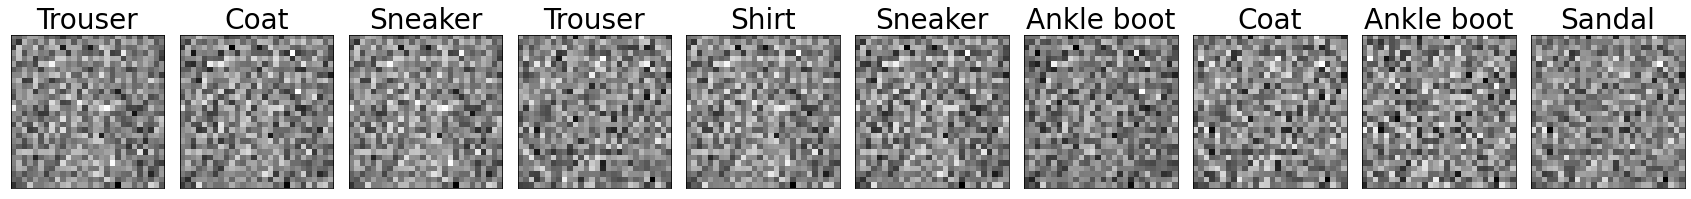

STEP: 250; Validation elbo (loss): -286.037109375


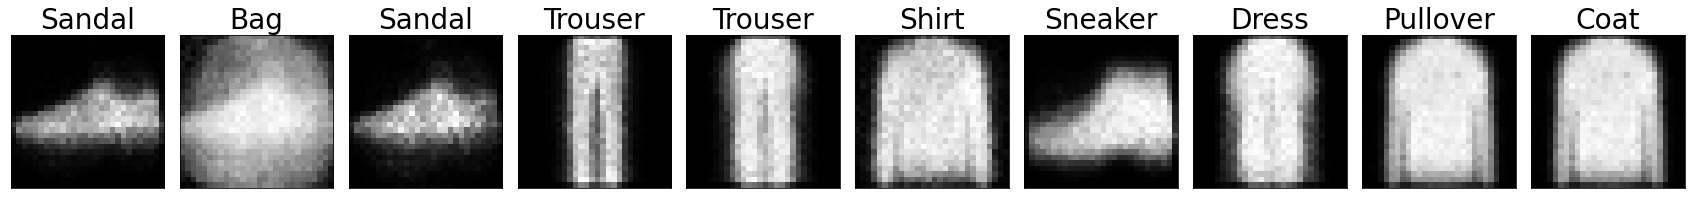

STEP: 500; Validation elbo (loss): -299.62091064453125


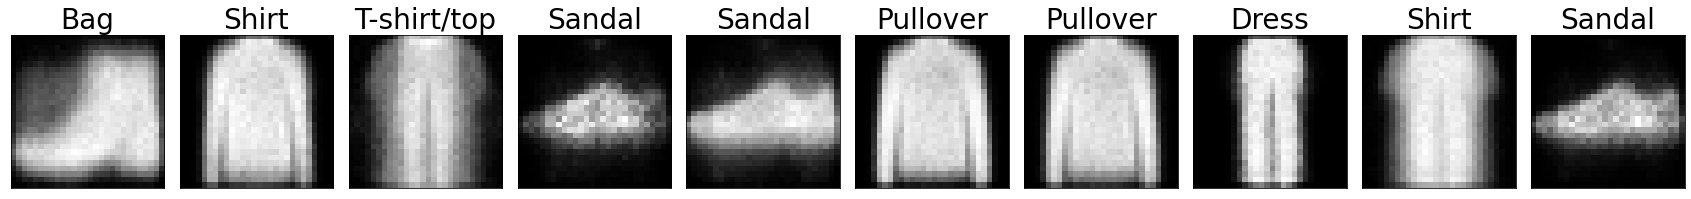

STEP: 750; Validation elbo (loss): -289.4627685546875


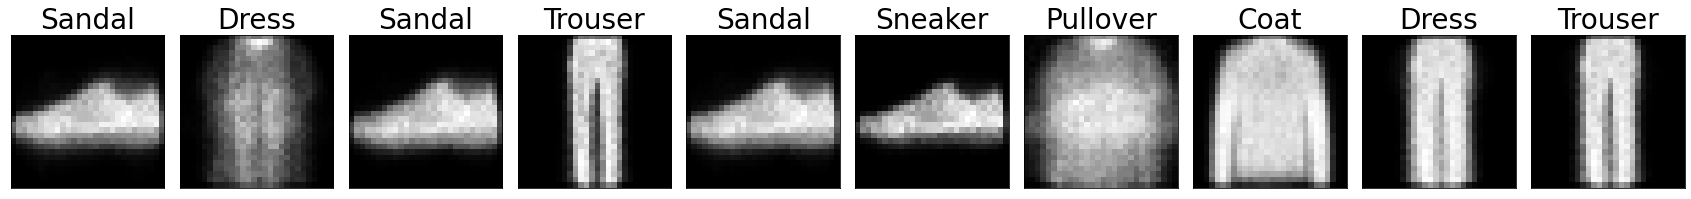

STEP: 1000; Validation elbo (loss): -278.88037109375


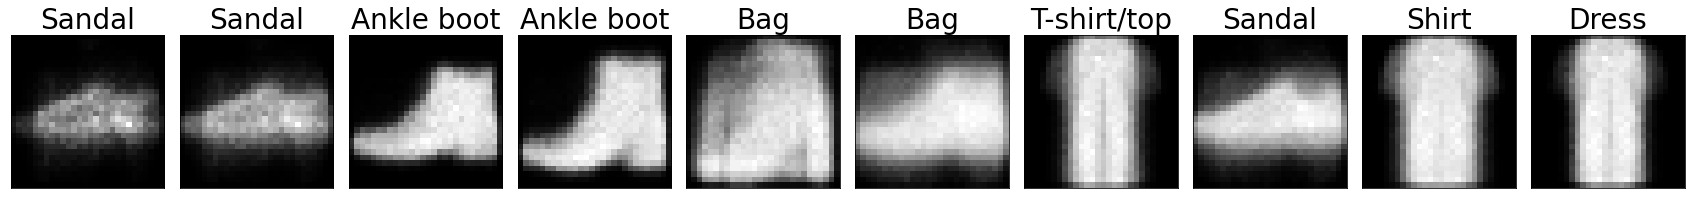

STEP: 1250; Validation elbo (loss): -280.7987365722656


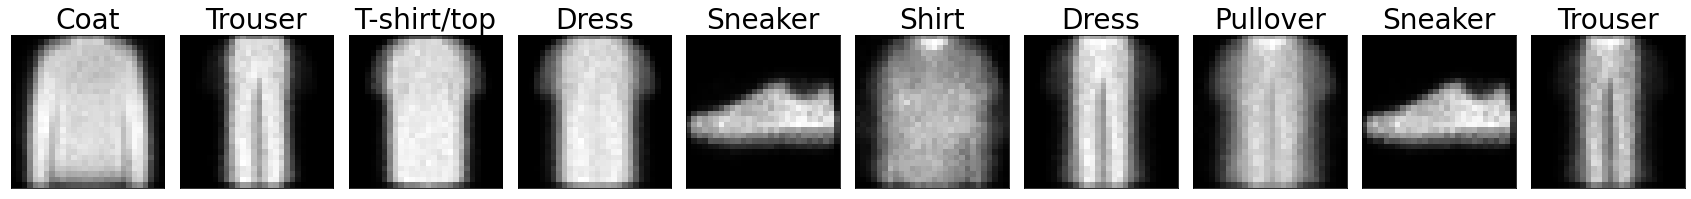

STEP: 1500; Validation elbo (loss): -271.25360107421875


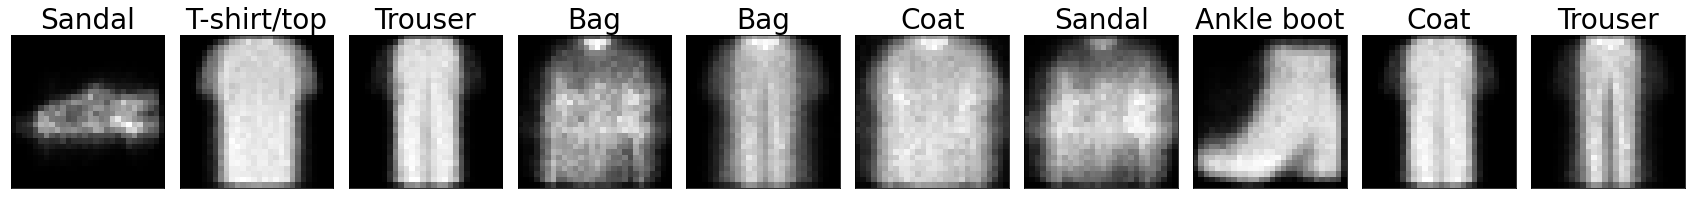

STEP: 1750; Validation elbo (loss): -277.07354736328125


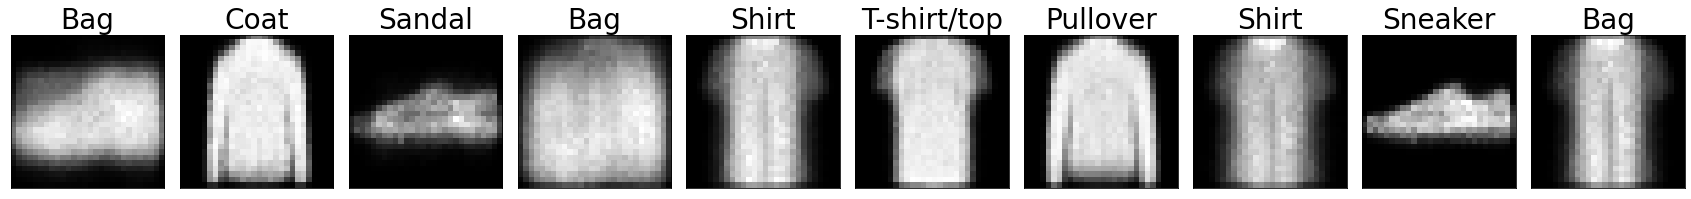

STEP: 2000; Validation elbo (loss): -274.6885681152344


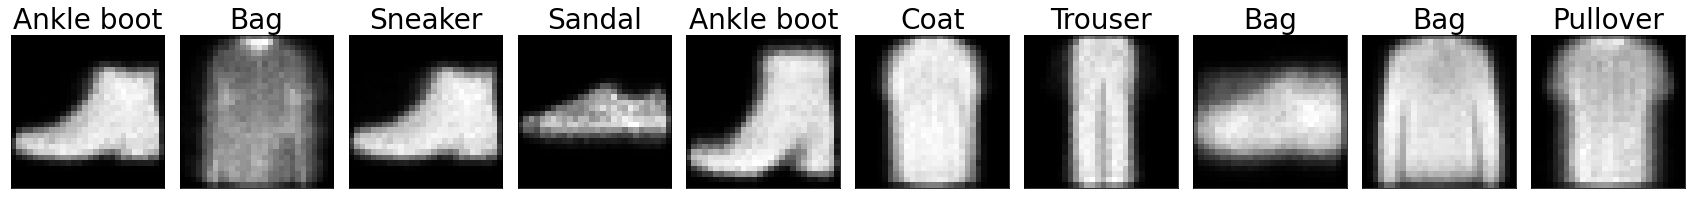

STEP: 2250; Validation elbo (loss): -266.27105712890625


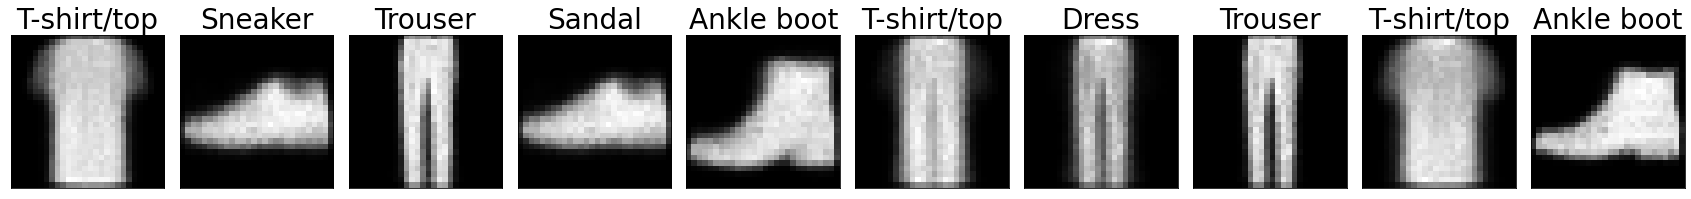

In [ ]:
#@title Training Loop
rng_seq = hk.PRNGSequence(42)
vae_model = hk.transform(
    lambda x: VariationalAutoEncoder(latent_size=2).reconstruct(x),
    apply_rng=True)  
optimizer = optix.adam(0.0001)


@jax.jit
def elbo_fn(params: hk.Params, rng_key: PRNGKey, batch: Batch) -> jnp.ndarray:
    """Return ELBO and its components"""
    images = batch["image"]
    output = vae_model.apply(params, rng_key, images)
    return elbo(images, output.logits, output.mean, output.stddev)


@jax.jit
def update(params: hk.Params, rng_key: PRNGKey, opt_state: OptState, 
           batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single update step."""
  def _just_loss(params, rng_key, batch):
    # NOTE the negative on the elbo!
    return -elbo_fn(params, rng_key, batch)[0]

  grads = jax.grad(_just_loss)(params, rng_key, batch)
  elbo, ll, kl = elbo_fn(params, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, new_opt_state, elbo, ll, kl


vae_params = vae_model.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = optimizer.init(vae_params)

train_ds = load_dataset(tfds.Split.TRAIN, 128)
valid_ds = load_dataset(tfds.Split.TEST, 128)

training_stats = defaultdict(list)
for step in range(2500):
  batch = next(train_ds)
  # Binarize like in https://github.com/google/jax/blob/master/examples/mnist_vae.py
  batch['image'] = jax.random.bernoulli(next(rng_seq), batch['image'])
  vae_params, opt_state, elb, ll, kl = update(vae_params, next(rng_seq), opt_state, batch)
  
  if step % 250 == 0:
    valid_batch = next(valid_ds)
    valid_batch['image'] = jax.random.bernoulli(next(rng_seq), valid_batch['image'])
    val_elb, val_ll, val_kl = elbo_fn(vae_params, next(rng_seq), valid_batch)
    print(f"STEP: {step}; Validation elbo (loss): {val_elb}")
    
    training_stats['val_elbo'].append(val_elb)
    training_stats['train_elbo'].append(elb)
    training_stats['val_kl'].append(val_kl)
    training_stats['train_kl'].append(kl)
    training_stats['val_ll'].append(val_ll)
    training_stats['train_ll'].append(ll)
    training_stats['step'].append(step)

    valid_output = vae_model.apply(
        vae_params, next(rng_seq), valid_batch["image"])
    gallery(valid_output.mean_image, valid_batch['label'])

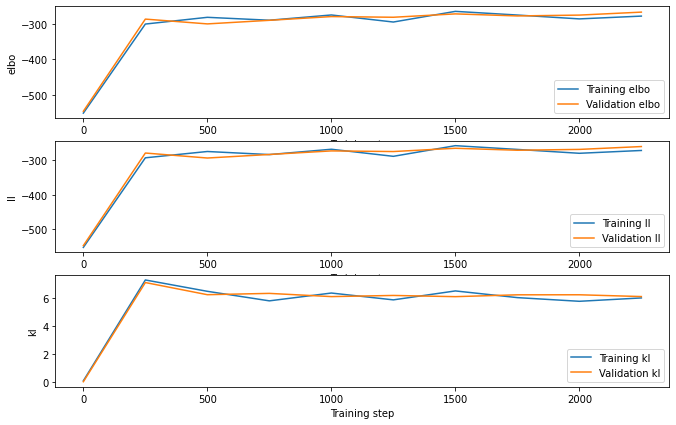

In [ ]:
#@title elbo, loglikelihood, kl
f, ax = plt.subplots(3, 1, figsize=(11, 7))
for key, axx in zip(['elbo', 'll', 'kl'], ax.reshape(-1,)):
  axx.plot(training_stats['step'], training_stats[f'train_{key}'], label=f"Training {key}")
  axx.plot(training_stats['step'], training_stats[f'val_{key}'], label=f"Validation {key}")
  axx.set_xlabel("Training step")
  axx.set_ylabel(key)
  axx.legend()

What do we observe based on the plot? What is a possible explanation of this?

Let's visualize reconstructions for training and validation data. Try visualiazing the mean image and the sampled image. When visualizing

In [ ]:
train_batch_viz = next(train_ds)
valid_batch_viz = next(valid_ds)
train_original_image = train_batch_viz['image']
valid_original_image = valid_batch_viz['image']
train_batch_viz['image'] = jax.random.bernoulli(next(rng_seq), train_batch_viz['image'])
valid_batch_viz['image'] = jax.random.bernoulli(next(rng_seq), valid_batch_viz['image'])


Train original then reconstruction under it:


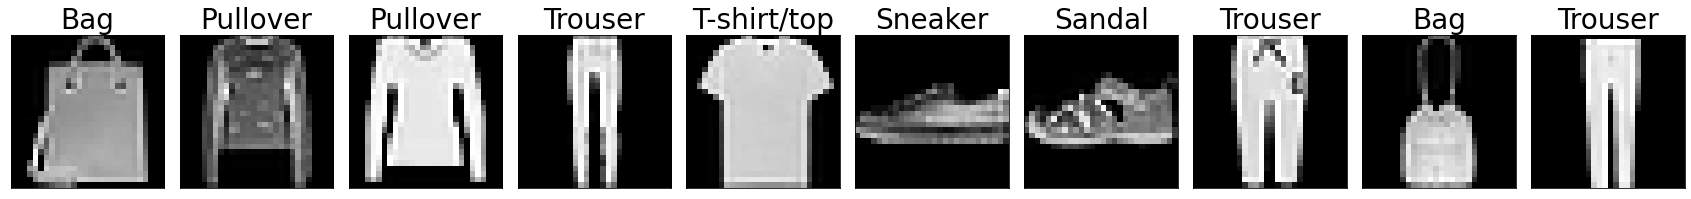

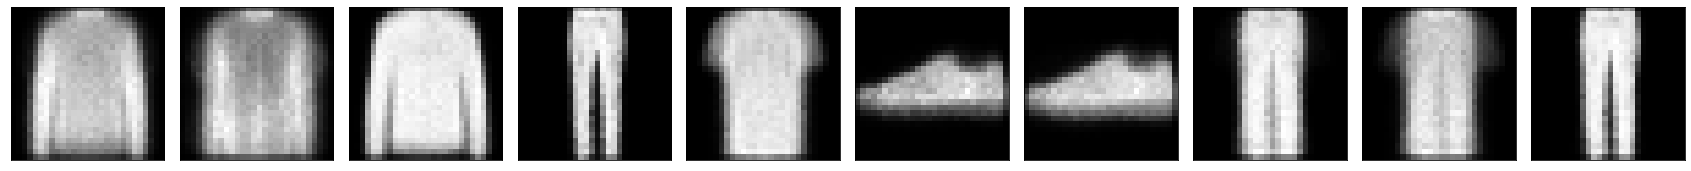

Validation original then reconstruction under it:


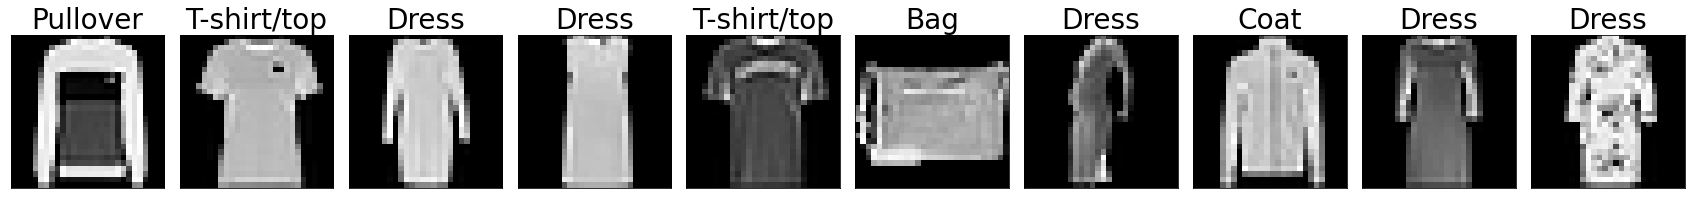

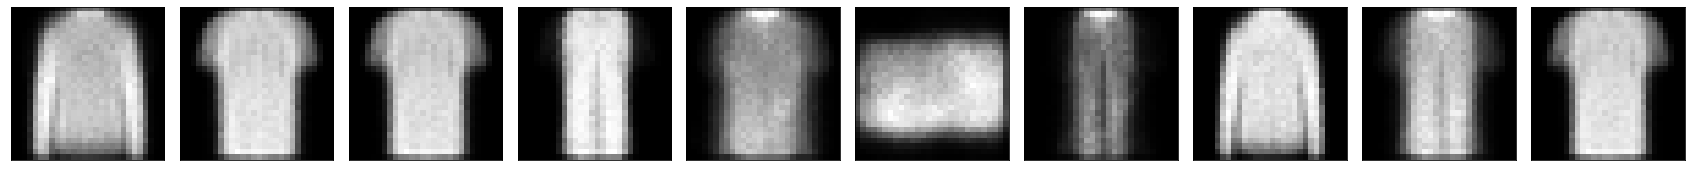

In [ ]:
#@title Reconstructions { run: "auto" }
visualize = 'mean_image' #@param ["mean_image", "sampled_image"] 

print("Train original then reconstruction under it:")
output = vae_model.apply(vae_params, rng_key, train_batch_viz["image"])
train_img = train_original_image if visualize == 'mean_image' else train_batch_viz['image']
gallery(train_img, train_batch_viz['label'])
gallery(getattr(output, visualize))

print("Validation original then reconstruction under it:")
output = vae_model.apply(vae_params, rng_key, valid_batch_viz["image"])
valid_img = valid_original_image if visualize == 'mean_image' else valid_batch_viz['image']
gallery(valid_img, valid_batch_viz['label'])
gallery(getattr(output, visualize))


In [ ]:
# Run checks
assert max(training_stats['train_elbo']) > -300
print("Congratulations! You have completed Task 4.")

Congratulations! You have completed Task 4.


# Task 5: Examine the latent variables learned by VAE

We inspect the latent space learned by the VAE. Recall,

1. When training our aim was to learn the true data distribution. More specifically, when we sample from the $\mathcal{N}(0, I)$ prior and decode those latents the resulting distribution should match that of the true dataset.

2. The KL component of the loss had a regularizer effect; in particular, it tries to keep the posteriors $q_\phi(z|x)$ close $\mathcal{N}(0, I)$.

Let's see what the latent space actually looks like.

We encode examples from the validation set and collect a sample from each posterior distribution.

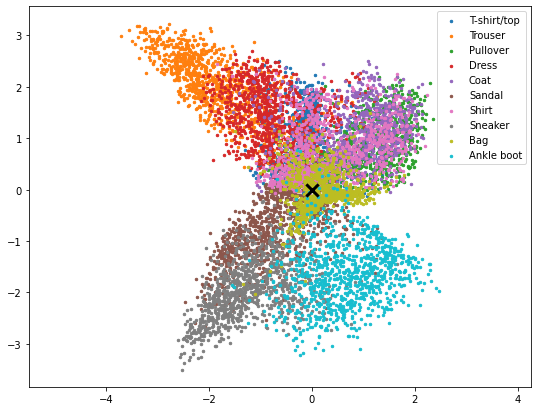

In [ ]:
#@title Visualizing q_(z|X)
## Note: this code assumes model has 2d latent space
zs, ys = [], []
for _ in range(75):
  valid_batch = next(valid_ds)
  valid_batch['image'] = jax.random.bernoulli(next(rng_seq), valid_batch['image'])
  zs.append(vae_model.apply(vae_params, next(rng_seq), valid_batch["image"]).z)
  ys.append(valid_batch['label'])
latents = np.concatenate(zs, axis=0)
labels = np.concatenate(ys, axis=0)
plt.figure(figsize=(9, 7))
for yy in range(10):
  plt.scatter(
      latents[labels==yy][:, 0], latents[labels==yy][:, 1],
      label=CLASS_LABELS[yy], s=6)
plt.legend()

plt.scatter([0],[0], marker="x", s=150, color="black", linewidth=3)
plt.axis('equal');


**Questions**:
1. Do you expect samples (ie decoded latents from $\mathcal{N}(0, I)$) to be "good"?
2. Do you expect samples to actually be similarly distributed to the real data? Why / Why not?
3. Can you think of some things that would affect how similar this distribution looks to the $\mathcal{N}(0, I)$ prior?  These could be ways we parametrize, train, or even new introduce new parameters.



Next we do a visual check for question 2. We show a grid of decoded latents.

Using the form, you can select between different ways of picking those latents:
* 'uniform': a uniform grid over [-2.5, 2.5] x [-2.5, 2.5],
* 'prior': the grid is transformed to reflect the density of the prior.


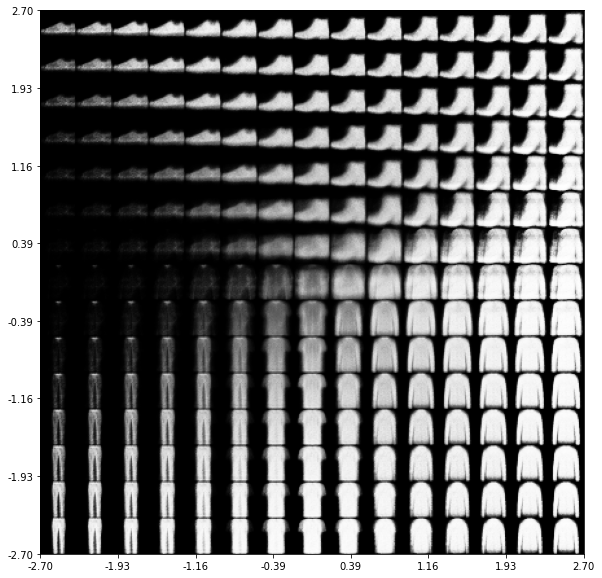

In [ ]:
#@title Visualizing samples  {run: 'auto'}
how = 'uniform' #@param ["uniform", "prior"] 

# Code borrowed from https://github.com/chaitanya100100/VAE-for-Image-Generation
decoder_only = hk.transform(
    lambda z: VariationalAutoEncoder(latent_size=2).decode(z), apply_rng=True) 

# display a 2D manifold of the decoded images
n = 15  # figure with 15x15 decoded images
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

linspace = np.linspace(0.05, 0.95, n)
if how == 'prior':
  grid_x = scipy.stats.norm.ppf(linspace)
  grid_y = scipy.stats.norm.ppf(linspace)
elif how == 'uniform':
  grid_x = 6*linspace -3
  grid_y = 6*linspace -3
else:
  assert 'Unrecognized `how` choice.'

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # mean_image, sampled_image
        xd_logits, xd_mean_image, _ = decoder_only.apply(
            vae_params, next(rng_seq), z_sample)
        digit = xd_mean_image[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
ax_min, ax_max = linspace[0], linspace[-1]
plt.imshow(figure, cmap='Greys_r', extent=[ax_min, ax_max, ax_min, ax_max])
grid_x_neat = ['{:0.2f}'.format(x) for x in grid_x]
plt.yticks(linspace[::2], grid_x_neat[::2])
plt.xticks(linspace[::2], grid_x_neat[::2])
plt.show()

# Regularized AutoEncoder

Can vanilla autoencoders generate visually good samples? Note that we are not concerned here with the ability to model the data density, but just being able to generate a nice looking image. 

The authors of https://arxiv.org/pdf/1903.12436.pdf argue that the answer is yes. They argue that by adding regularization and "ex-post density estimation" (Sec.4) -- meaning looking at the distribution of latents produced and fitting a distribution to that -- a vanilla autoencoder facilitates generating high quality samples.

We highly encourage you to at least check the paper out as it ties in nicely with this tutorial. We do hope you will also find the homework exercise rewarding!

## Homework: Implement and experiment with a Regularized AutoEncoder

This is a more open-ended exercise than previous in the notebook. 

Your tasks are: 
1. Investigate how samples look if we use latent size of 2. Do the samples look better compared to using latent size of 50? If they do, do you have an explanation for why the samples are better? 
2. Implement and train Regularized AutoEncoder from https://arxiv.org/pdf/1903.12436.pdf by adding the second term to the loss function from Eq (11) in https://arxiv.org/pdf/1903.12436.pdf. 
3. Investigate whether the added regularization (1) improves the quality of the generated samples when coupled with ex-post density estimation, (2) reduces mean squared error of reconstructed images on the validation set (you can just use mse_loss_fn to calculate it). Remember to check a few different values of the regularization constant.

To help you get started, we provide below code that implements a simple version of ex-post density estimation to sample from our AutoEncoder. The sampling procedure is very similar to that used with Variational AutoEncoder. We will sample a latent variable $z$ from a normal distribution and feed it to the decoder. The main difference is that we will estimate mean and variance of the normal distribution.

We use a higher dimensional latent space for the purposes of this exercise to better highlight challenges with generating samples without regularizing the autoencoder.  Note, if you want to visualize high dimensional latent spaces, you might want to use the t-sne dimensionality reduction method (e.g. through `sklearn.manifold.TSNE`).


---

In [ ]:
# Train a lager dimensional model.
# RAE_LATENT_SIZE = 2
RAE_LATENT_SIZE = 50
rae_model = hk.transform(
    lambda x: AutoEncoder(latent_size=RAE_LATENT_SIZE).reconstruct(x), apply_rng=True)  
optimizer = optix.adam(0.0001)

@jax.jit
def mse_loss_fn(params: hk.Params, rng_key: PRNGKey, batch: Batch) -> jnp.ndarray:
  """Mean Squared Error loss function."""
  outputs, _ = rae_model.apply(params, rng_key, batch["image"])
  return jnp.mean(jnp.power(batch['image'] - outputs, 2.0))

@jax.jit
def update(params: hk.Params, rng_key: PRNGKey, opt_state: OptState, 
           batch: Batch) -> Tuple[hk.Params, OptState]:
  """Single SGD update step."""
  grads = jax.grad(mse_loss_fn)(params, rng_key, batch)
  loss = mse_loss_fn(params, rng_key, batch)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optix.apply_updates(params, updates)
  return new_params, new_opt_state, loss

rae_params = rae_model.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = optimizer.init(rae_params)

train_ds = load_dataset(tfds.Split.TRAIN, 128)
valid_ds = load_dataset(tfds.Split.TEST, 128)

training_stats = defaultdict(list)
for step in range(1000):
  rae_params, opt_state, loss = update(rae_params, next(rng_seq), opt_state, next(train_ds))
  
  if step % 100 == 0:
    valid_batch = next(valid_ds)
    val_loss = mse_loss_fn(rae_params, next(rng_seq), valid_batch)
    print(f"STEP: {step}; Validation loss: {val_loss}")
    
    training_stats['val_loss'].append(val_loss)
    training_stats['train_loss'].append(loss)
    training_stats['step'].append(step)

    valid_rec, _ = rae_model.apply(rae_params, next(rng_seq), valid_batch["image"])

STEP: 0; Validation loss: 0.20318622887134552
STEP: 100; Validation loss: 0.039308302104473114
STEP: 200; Validation loss: 0.028802672401070595
STEP: 300; Validation loss: 0.02322162687778473
STEP: 400; Validation loss: 0.022061733528971672
STEP: 500; Validation loss: 0.01960412971675396
STEP: 600; Validation loss: 0.019274525344371796
STEP: 700; Validation loss: 0.018296880647540092
STEP: 800; Validation loss: 0.017158474773168564
STEP: 900; Validation loss: 0.015444022603332996


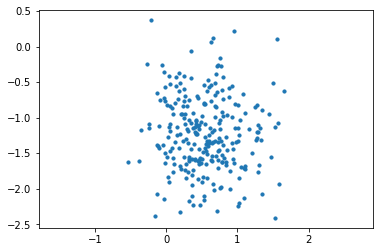

In [ ]:
# Run simple ex-post density estimation
latents = []
for _ in range(10):
  valid_batch = next(valid_ds)
  _, z = rae_model.apply(rae_params, next(rng_seq), valid_batch["image"])
  latents.append(z)
latents = np.concatenate(latents, axis=0)
H_mean, H_std = np.mean(latents, axis=0), np.std(latents, axis=0)
H_sampled = np.random.normal(loc=H_mean, scale=H_std, size=(2*128, RAE_LATENT_SIZE)) 
plt.scatter(H_sampled[:, 0], H_sampled[:, 1], s=10)

plt.axis('equal');

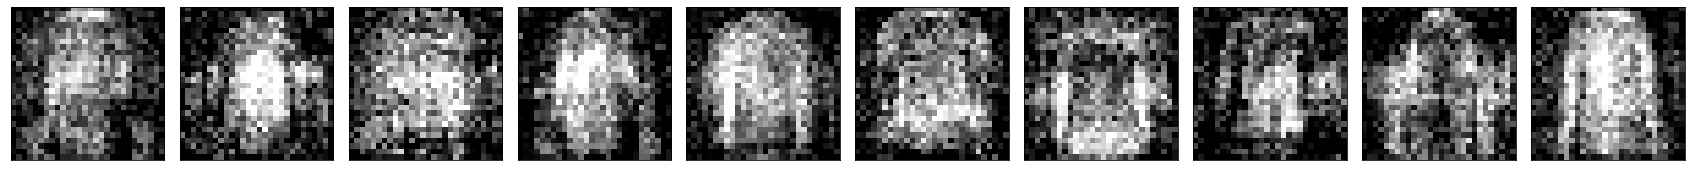

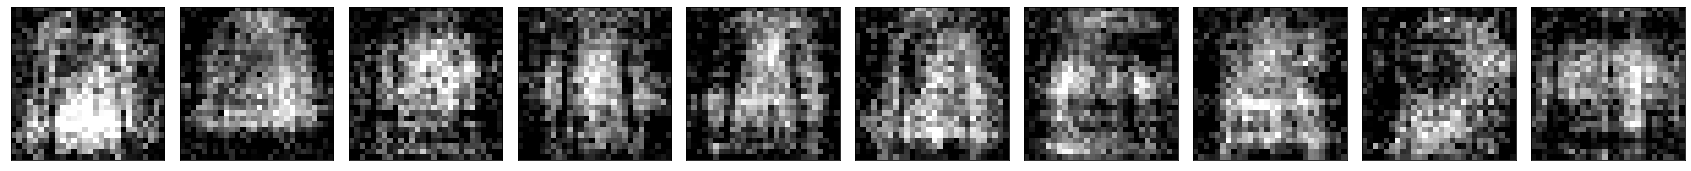

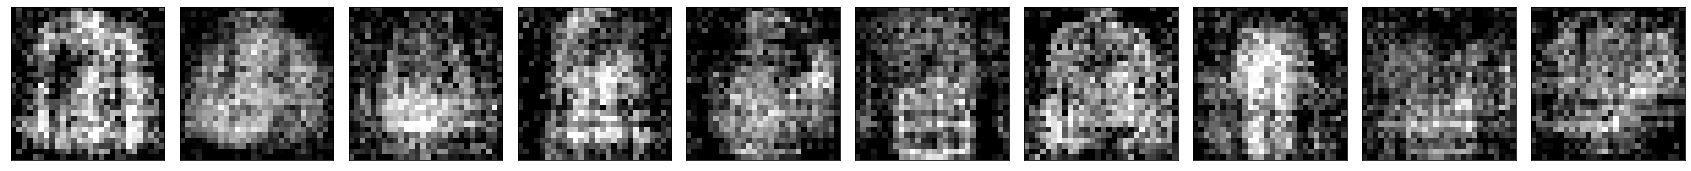

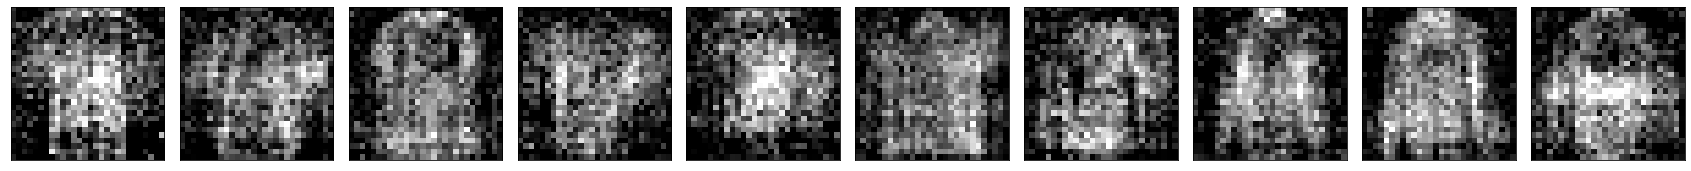

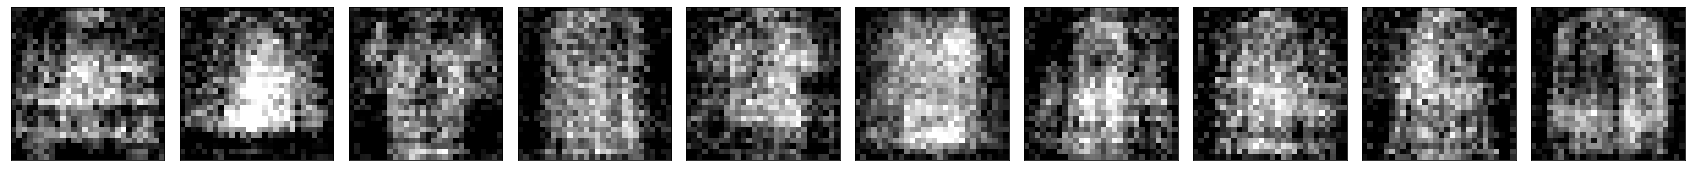

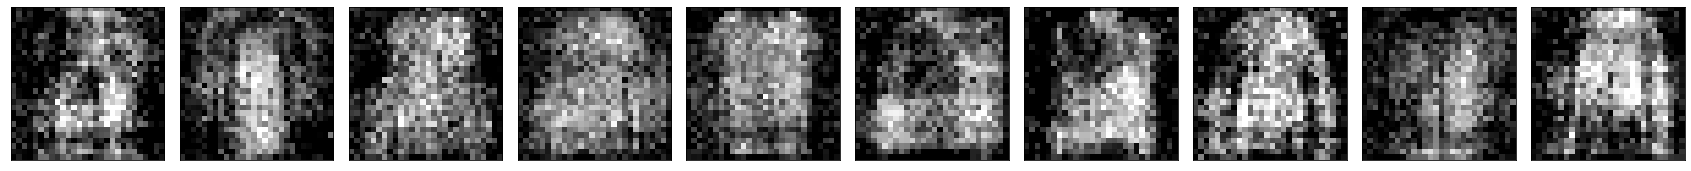

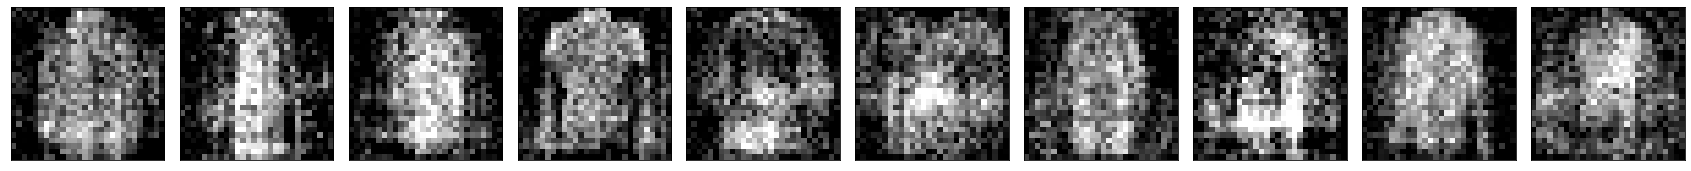

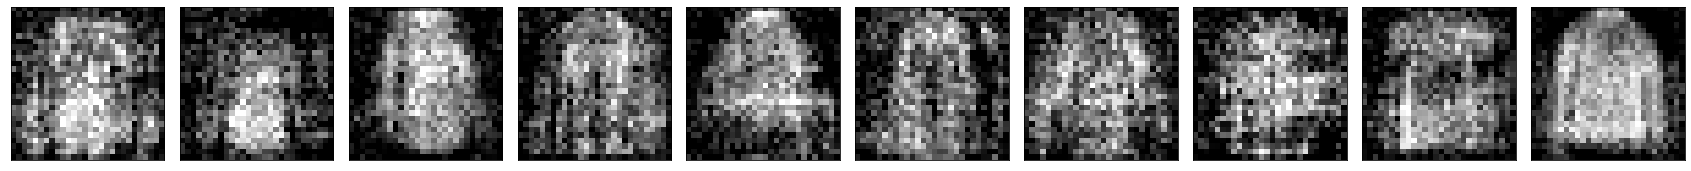

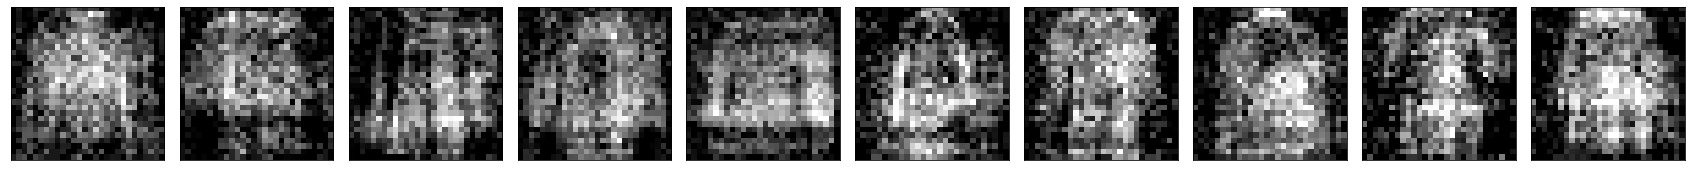

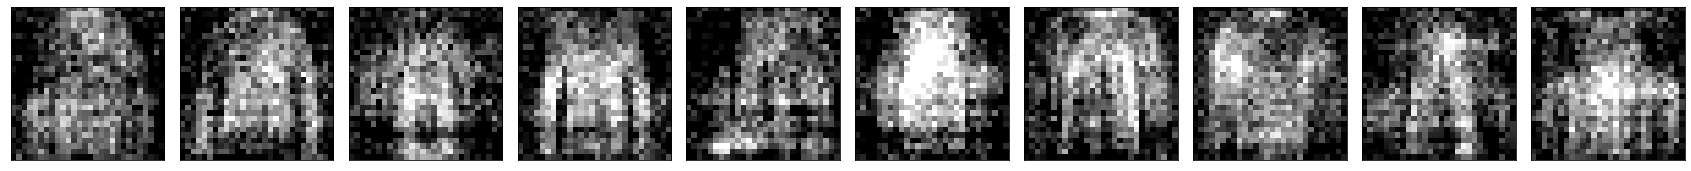

In [ ]:
# Create model that doesn't use encoder 
rae_decoder_only = hk.transform(
    lambda z: AutoEncoder(latent_size=RAE_LATENT_SIZE).sample(z), apply_rng=True) 
# Use it to sample from the model
for _ in range(10):
  H_sampled = np.random.normal(loc=H_mean, scale=H_std, size=(10, RAE_LATENT_SIZE)) 
  x_decoded = rae_decoder_only.apply(rae_params, next(rng_seq), H_sampled)
  gallery(x_decoded)

# Further Reading

A number of papers investigate sampling and reconstruction, the structure of latent space both theoretically and through empirical studies. Here is a small selection of possible further readings:

* Taming VAE: https://arxiv.org/pdf/1810.00597.pdf
* Fixing a Broken ELBO: https://arxiv.org/pdf/1711.00464.pdf
* Distribution Matching in Variational Inference: https://arxiv.org/pdf/1802.06847.pdf

Finally, [VQ-VAE](https://arxiv.org/pdf/1906.00446.pdf) which uses many concepts we touched on here, though with a discrete latent space and produces beautiful images.

# Credits

Inspired by:
* https://github.com/deepmind/dm-haiku/blob/master/examples/vae.py
* https://github.com/gmum/ml2019-20/blob/master/lab/13_VAE.ipynb
* https://github.com/chaitanya100100/VAE-for-Image-Generation
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/